# Assignment3 (GAN)

In [1]:
name = input("Name :")
ID = input("student ID :")

Name :윤정란
student ID :2312748


## Prepare

In [2]:
import numpy as np
import time

import matplotlib.pyplot as plt
import torchvision.utils

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

### Data Load with augmnetation

In [3]:
#load dataset
dataset = 'mnist'
resolution = 32
batch_size = 64
num_workers = 1

transform = transforms.Compose([transforms.Resize(resolution),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

if dataset == 'cifar10':
  dataset = datasets.CIFAR10(root='./data/Cifar10', train=True, download=True, transform=transform)
  data_dim = 3

elif dataset == 'mnist':
  dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
  data_dim = 1

train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4497461.86it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 127748.73it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:11<00:00, 149679.94it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10672565.14it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



### utils

1. model weight initialization

In [4]:
def initialize_weights(net):
	for m in net.modules():
		if isinstance(m, nn.Conv2d):
			m.weight.data.normal_(0, 0.02)
			if m.bias is not None:
				m.bias.data.zero_()
		elif isinstance(m, nn.ConvTranspose2d):
			m.weight.data.normal_(0, 0.02)
			if m.bias is not None:
				m.bias.data.zero_()
		elif isinstance(m, nn.Conv3d):
			nn.init.xavier_uniform(m.weight)
		elif isinstance(m, nn.ConvTranspose3d):
			nn.init.xavier_uniform(m.weight)
		#elif isinstance(m, nn.GRU):
		#	nn.init.xavier_uniform(m.weight)
		elif isinstance(m, nn.Linear):
			m.weight.data.normal_(0, 0.02)
			m.bias.data.zero_()

2. for image

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img): # image visualization (input = image)
    plt.ion()
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_images(Generator, fixed_z): # generated image visualization (input = model(G) and latent vector)
    Generator.eval()
    with torch.no_grad():
        # sample latent vectors from the standard normal distribution
        fake_image_batch = Generator(fixed_z)
        fake_image_batch = fake_image_batch.cpu()

        fig, ax = plt.subplots(figsize=(8, 8))
        show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
        plt.show()
    Generator.train(True)

## Model

### Generator

In [6]:
class Gen(nn.Module):
	def __init__(self, output_dim):
		super(Gen, self).__init__()
		self.input_dim = 100 #원하는 채널 수로 변경해도 됩니다!
		self.output_dim = output_dim

		self.deconv = nn.Sequential(
			# 1 -> 4
			nn.Conv2d(self.input_dim, 256, 4, 1, 3, bias=False),
			nn.BatchNorm2d(256),
			nn.ReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),

			# 4 -> 8
			##과제##
			## - 해당 부분을 채우세요 - ##
			##Convolution layer -> Normalization -> Activation function -> Upsample 순서로 채우세요 #
			## - 해당 부분을 채우세요 - ##
			##과제##
			nn.Conv2d(256, 128, 3, 1, 1, bias=False),
			nn.BatchNorm2d(128),
			nn.ReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),

			# 8 -> 16
			##과제##
			## - 해당 부분을 채우세요 - ##
			##Convolution layer -> Normalization -> Activation function -> Upsample 순서로 채우세요 #
			## - 해당 부분을 채우세요 - ##
			##과제##
			nn.Conv2d(128, 64, 3, 1, 1, bias=False),
			nn.BatchNorm2d(64),
			nn.ReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),

			#16 -> 32
			nn.Conv2d(64, self.output_dim, 3, 1, 1, bias=False),
			nn.Tanh(),
		)

		initialize_weights(self)

	def forward(self, z):
		x = z.view(-1, self.input_dim, 1, 1)
		x = self.deconv(x)
		return x

## Discriminator

In [7]:
class Dis(nn.Module):
	def __init__(self, input_dim):
		super(Dis, self).__init__()
		self.input_dim = input_dim
		self.output_dim  = 1 # Real or Fake

		self.conv = nn.Sequential(
			# 32 ->16
			##과제##
			## - 해당 부분을 채우세요 - ##
			##Convolution layer -> Normalization -> Activation function  순서로 채우세요 #
			## - 해당 부분을 채우세요 - ##
			##과제##
			nn.Conv2d(self.input_dim, 64, 4, 2, 1, bias=False),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(0.2),
		)

		self.fc = nn.Sequential(
			##과제##
			## - 해당 부분을 채우세요 - ##
			##Linear layer -> Normalization -> Activation function  순서로 채우세요 #
			## - 해당 부분을 채우세요 - ##
			##과제##
			nn.Linear(64*16*16, 512),
			nn.BatchNorm1d(512),
			nn.LeakyReLU(0.2),

			##과제##
			## - 해당 부분을 채우세요 - ##
			##Linear layer -> Normalization -> Activation function  순서로 채우세요 #
			## - 해당 부분을 채우세요 - ##
			##과제##
			nn.Linear(512, 256),
			nn.BatchNorm1d(256),
			nn.LeakyReLU(0.2),

			nn.Linear(256, self.output_dim),
			nn.Sigmoid(),
		)

		initialize_weights(self)

	def forward(self, input):
		x = self.conv(input)
		x = self.fc(x.view(-1,64*16*16))
		return x

## Adversarial Training

Hyperparameter

In [8]:
total_epoch = 10

beta1 = 0.5
beta2 = 0.999
lrG = 0.00005 #0.0002
lrD = 0.00005 #0.0002


Model & Optimizer & Loss

In [9]:
#construct model G & D
Generator = Gen(data_dim)
Discriminator = Dis(data_dim)

#define optimizer for G & D
G_optimizer = optim.Adam(Generator.parameters(), lr=lrG, betas=(beta1, beta2))
D_optimizer = optim.Adam(Discriminator.parameters(), lr=lrD, betas=(beta1, beta2))


Generator = Generator.cuda()
Discriminator = Discriminator.cuda()
BCE_loss = nn.BCELoss().cuda() #BCELoss : Binary Cross Entropy Loss

Training

Dataset Length  60000
[E000]  G_loss :  0.604988   D_loss :  1.401169 = 0.774900 + 0.626268
[E000]  G_loss :  0.697771   D_loss :  1.336844 = 0.670991 + 0.665854
[E000]  G_loss :  0.711836   D_loss :  1.302844 = 0.651932 + 0.650912
[E000]  G_loss :  0.702963   D_loss :  1.313832 = 0.665091 + 0.648741
[E000]  G_loss :  0.705941   D_loss :  1.268746 = 0.653952 + 0.614794
[E000]  G_loss :  0.701734   D_loss :  1.295580 = 0.660215 + 0.635364
[E000]  G_loss :  0.697160   D_loss :  1.287019 = 0.658085 + 0.628934
[E000]  G_loss :  0.708070   D_loss :  1.279142 = 0.647139 + 0.632003
[E000]  G_loss :  0.704430   D_loss :  1.269477 = 0.639525 + 0.629953
[E000]  G_loss :  0.714967   D_loss :  1.268062 = 0.643630 + 0.624432


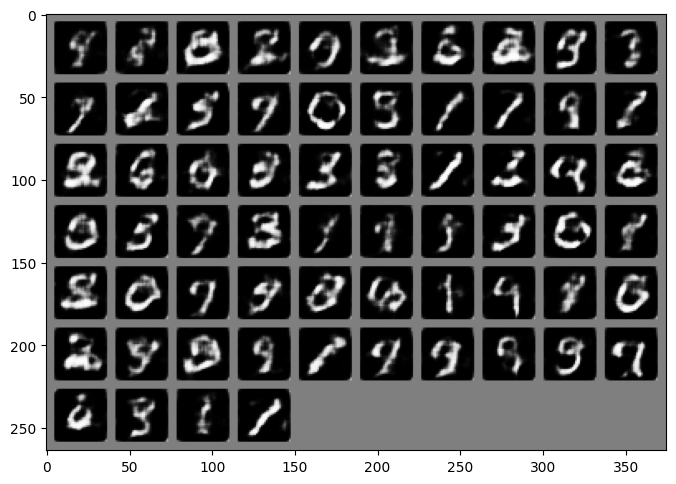

[E001]  G_loss :  0.698007   D_loss :  1.260897 = 0.644890 + 0.616008
[E001]  G_loss :  0.717019   D_loss :  1.308682 = 0.643468 + 0.665214
[E001]  G_loss :  0.707654   D_loss :  1.289793 = 0.645290 + 0.644502
[E001]  G_loss :  0.691996   D_loss :  1.285114 = 0.646042 + 0.639072
[E001]  G_loss :  0.707142   D_loss :  1.250924 = 0.630058 + 0.620866
[E001]  G_loss :  0.713647   D_loss :  1.245363 = 0.634105 + 0.611259
[E001]  G_loss :  0.746508   D_loss :  1.208478 = 0.590037 + 0.618440
[E001]  G_loss :  0.727598   D_loss :  1.250858 = 0.613853 + 0.637005
[E001]  G_loss :  0.721404   D_loss :  1.274755 = 0.632396 + 0.642359
[E001]  G_loss :  0.719921   D_loss :  1.247000 = 0.626006 + 0.620995


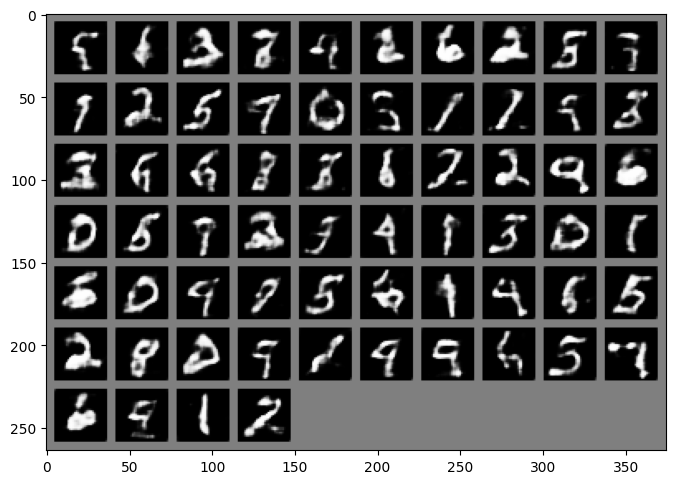

[E002]  G_loss :  0.697920   D_loss :  1.236673 = 0.632752 + 0.603922
[E002]  G_loss :  0.712948   D_loss :  1.185136 = 0.592876 + 0.592260
[E002]  G_loss :  0.706155   D_loss :  1.234085 = 0.639715 + 0.594370
[E002]  G_loss :  0.721635   D_loss :  1.202474 = 0.617320 + 0.585153
[E002]  G_loss :  0.702501   D_loss :  1.183638 = 0.607068 + 0.576570
[E002]  G_loss :  0.727143   D_loss :  1.219023 = 0.611738 + 0.607284
[E002]  G_loss :  0.703454   D_loss :  1.191278 = 0.629490 + 0.561788
[E002]  G_loss :  0.743558   D_loss :  1.213093 = 0.610070 + 0.603023
[E002]  G_loss :  0.715922   D_loss :  1.280599 = 0.626382 + 0.654217
[E002]  G_loss :  0.751956   D_loss :  1.174781 = 0.565953 + 0.608828


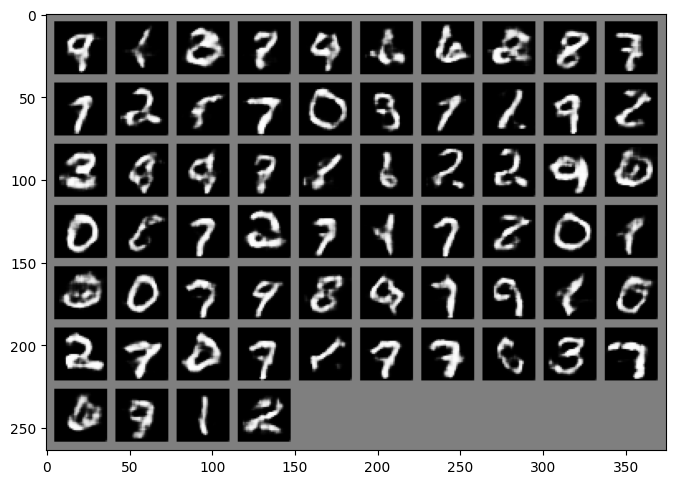

[E003]  G_loss :  0.730944   D_loss :  1.223108 = 0.605136 + 0.617972
[E003]  G_loss :  0.693997   D_loss :  1.213395 = 0.649043 + 0.564351
[E003]  G_loss :  0.740234   D_loss :  1.168773 = 0.608487 + 0.560286
[E003]  G_loss :  0.707134   D_loss :  1.209285 = 0.634554 + 0.574731
[E003]  G_loss :  0.717105   D_loss :  1.214037 = 0.635293 + 0.578744
[E003]  G_loss :  0.708455   D_loss :  1.181078 = 0.635237 + 0.545840
[E003]  G_loss :  0.708870   D_loss :  1.248721 = 0.620366 + 0.628354
[E003]  G_loss :  0.728804   D_loss :  1.149121 = 0.597817 + 0.551304
[E003]  G_loss :  0.734025   D_loss :  1.121149 = 0.561172 + 0.559977
[E003]  G_loss :  0.774792   D_loss :  1.242597 = 0.550146 + 0.692451


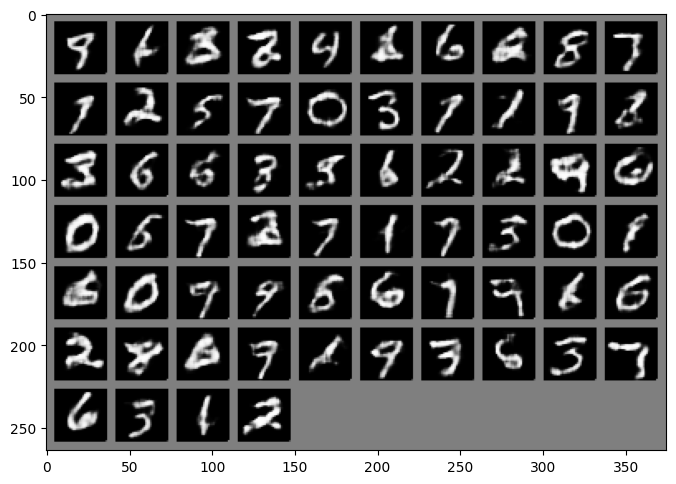

[E004]  G_loss :  0.712238   D_loss :  1.125656 = 0.567631 + 0.558025
[E004]  G_loss :  0.694455   D_loss :  1.106320 = 0.582346 + 0.523973
[E004]  G_loss :  0.728198   D_loss :  1.188189 = 0.595373 + 0.592817
[E004]  G_loss :  0.706976   D_loss :  1.196788 = 0.613418 + 0.583370
[E004]  G_loss :  0.708843   D_loss :  1.082504 = 0.555505 + 0.526999
[E004]  G_loss :  0.775678   D_loss :  1.199715 = 0.562186 + 0.637529
[E004]  G_loss :  0.772186   D_loss :  1.206200 = 0.568957 + 0.637243
[E004]  G_loss :  0.738143   D_loss :  1.150533 = 0.578882 + 0.571651
[E004]  G_loss :  0.748362   D_loss :  1.070481 = 0.544141 + 0.526340
[E004]  G_loss :  0.704356   D_loss :  1.136151 = 0.591976 + 0.544175


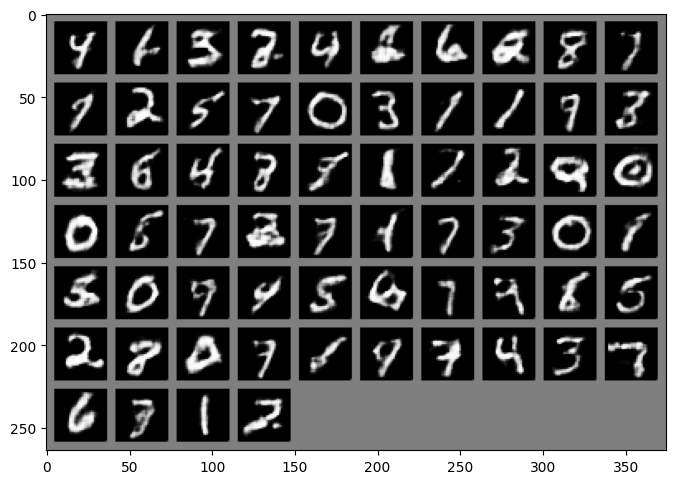

[E005]  G_loss :  0.744010   D_loss :  1.128487 = 0.594367 + 0.534120
[E005]  G_loss :  0.736594   D_loss :  1.095691 = 0.552935 + 0.542755
[E005]  G_loss :  0.768420   D_loss :  1.155091 = 0.567379 + 0.587712
[E005]  G_loss :  0.724213   D_loss :  1.156218 = 0.588340 + 0.567878
[E005]  G_loss :  0.762293   D_loss :  1.175773 = 0.546018 + 0.629754
[E005]  G_loss :  0.770893   D_loss :  1.095631 = 0.539450 + 0.556181
[E005]  G_loss :  0.726416   D_loss :  1.076515 = 0.539380 + 0.537136
[E005]  G_loss :  0.745240   D_loss :  1.084198 = 0.528410 + 0.555788
[E005]  G_loss :  0.698739   D_loss :  1.133420 = 0.568433 + 0.564987
[E005]  G_loss :  0.734660   D_loss :  1.137673 = 0.551729 + 0.585944


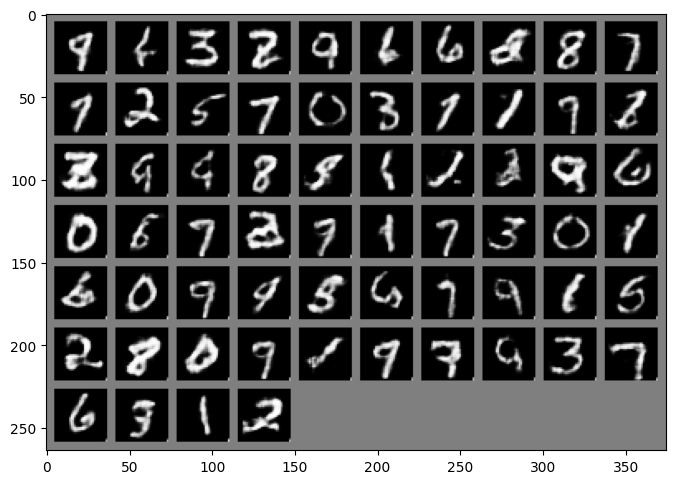

[E006]  G_loss :  0.730208   D_loss :  1.140725 = 0.572971 + 0.567755
[E006]  G_loss :  0.703499   D_loss :  1.092746 = 0.595288 + 0.497458
[E006]  G_loss :  0.691995   D_loss :  1.044154 = 0.569664 + 0.474490
[E006]  G_loss :  0.734607   D_loss :  1.078848 = 0.535410 + 0.543438
[E006]  G_loss :  0.667881   D_loss :  1.125301 = 0.598038 + 0.527263
[E006]  G_loss :  0.815501   D_loss :  1.131048 = 0.538731 + 0.592317
[E006]  G_loss :  0.716495   D_loss :  1.110169 = 0.634471 + 0.475698
[E006]  G_loss :  0.823374   D_loss :  1.162199 = 0.511808 + 0.650391
[E006]  G_loss :  0.743944   D_loss :  1.180179 = 0.596984 + 0.583195
[E006]  G_loss :  0.731743   D_loss :  1.108523 = 0.591088 + 0.517435


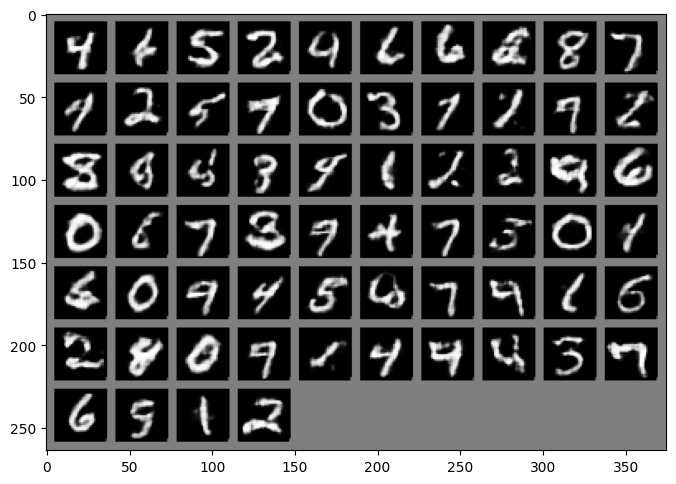

[E007]  G_loss :  0.727226   D_loss :  1.087083 = 0.564180 + 0.522902
[E007]  G_loss :  0.722060   D_loss :  1.183198 = 0.635000 + 0.548198
[E007]  G_loss :  0.771360   D_loss :  1.075390 = 0.533714 + 0.541676
[E007]  G_loss :  0.744306   D_loss :  1.092154 = 0.552033 + 0.540121
[E007]  G_loss :  0.751891   D_loss :  1.036172 = 0.532651 + 0.503521
[E007]  G_loss :  0.814848   D_loss :  1.111253 = 0.548922 + 0.562331
[E007]  G_loss :  0.725826   D_loss :  1.006054 = 0.545208 + 0.460847
[E007]  G_loss :  0.794991   D_loss :  1.029286 = 0.512348 + 0.516938
[E007]  G_loss :  0.658512   D_loss :  1.065052 = 0.563165 + 0.501887
[E007]  G_loss :  0.794219   D_loss :  1.128841 = 0.509511 + 0.619330


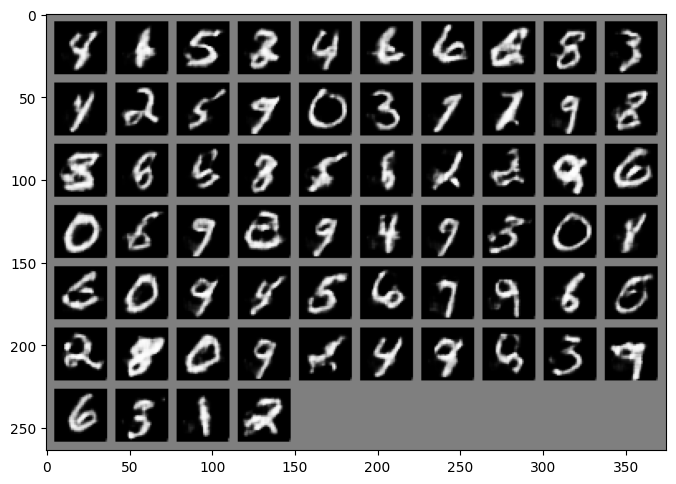

[E008]  G_loss :  0.863985   D_loss :  1.097223 = 0.478467 + 0.618756
[E008]  G_loss :  0.783758   D_loss :  1.039692 = 0.531960 + 0.507732
[E008]  G_loss :  0.737823   D_loss :  1.052958 = 0.532330 + 0.520628
[E008]  G_loss :  0.735259   D_loss :  1.139468 = 0.573686 + 0.565782
[E008]  G_loss :  0.820804   D_loss :  1.007506 = 0.471482 + 0.536024
[E008]  G_loss :  0.847449   D_loss :  1.084811 = 0.490694 + 0.594117
[E008]  G_loss :  0.808389   D_loss :  1.042048 = 0.470442 + 0.571606
[E008]  G_loss :  0.826135   D_loss :  1.049947 = 0.466103 + 0.583844
[E008]  G_loss :  0.756489   D_loss :  1.082949 = 0.542799 + 0.540150
[E008]  G_loss :  0.750753   D_loss :  1.092675 = 0.576543 + 0.516133


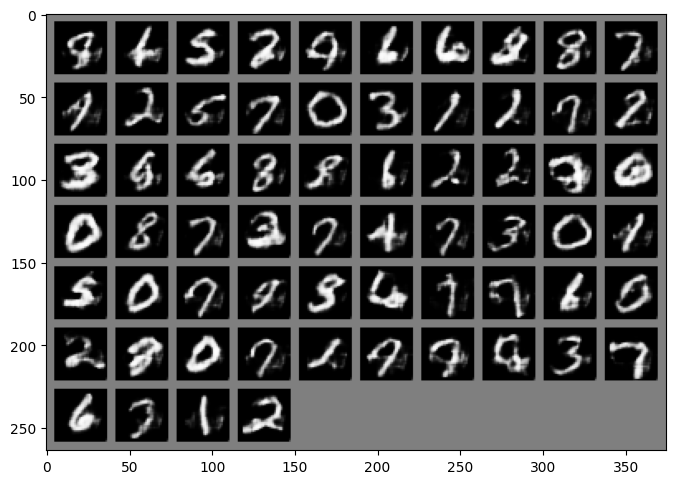

[E009]  G_loss :  0.776014   D_loss :  1.021264 = 0.512709 + 0.508554
[E009]  G_loss :  0.738769   D_loss :  1.029350 = 0.529701 + 0.499650
[E009]  G_loss :  0.766242   D_loss :  1.015369 = 0.521476 + 0.493893
[E009]  G_loss :  0.772390   D_loss :  1.022743 = 0.515928 + 0.506815
[E009]  G_loss :  0.746799   D_loss :  0.976900 = 0.487733 + 0.489166
[E009]  G_loss :  0.764994   D_loss :  1.012275 = 0.491844 + 0.520432
[E009]  G_loss :  0.935601   D_loss :  0.943285 = 0.421029 + 0.522255
[E009]  G_loss :  0.748975   D_loss :  1.081596 = 0.545366 + 0.536230
[E009]  G_loss :  0.698335   D_loss :  0.983698 = 0.569164 + 0.414534
[E009]  G_loss :  0.768690   D_loss :  1.079317 = 0.566999 + 0.512319


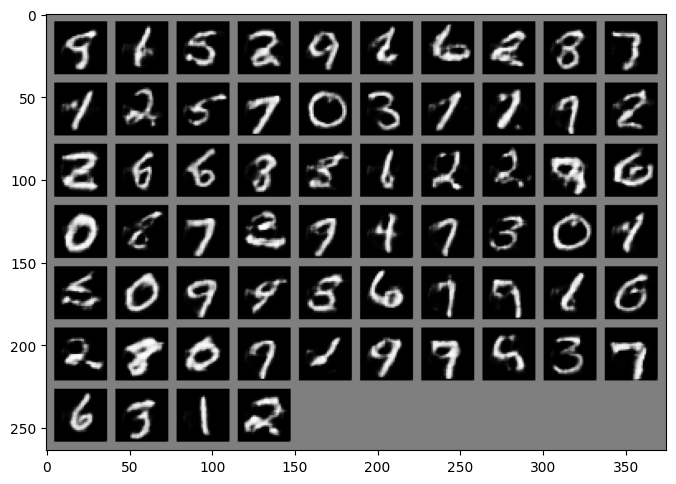

In [10]:

y_real_, y_fake_ = Variable(torch.ones(batch_size, 1).cuda()), Variable(torch.zeros(batch_size, 1).cuda())
fixed_z = Variable(torch.rand(batch_size, 100).cuda())


#train start!
Discriminator.train()
start_time = time.time()

print("Dataset Length ", train_loader.dataset.__len__())

for epoch in range(total_epoch):
  Generator.train()
  epoch_start_time = time.time()

  for iB, (img_,_) in enumerate(train_loader):
    if iB == train_loader.dataset.__len__() // batch_size:
      break

    #Latent space
    ## z_ -> ( batch_size x 100 ) uniform distribution / randn_ : normal gaussian distribution
    z_ = torch.rand(batch_size, 100)

    z_, img_ = Variable(z_.cuda()), Variable(img_.cuda())


    #----Update D_network----#
    D_optimizer.zero_grad()

    D_real = Discriminator(img_)
    D_real_loss = BCE_loss(D_real, y_real_)

    fake_img_ = Generator(z_)
    D_fake = Discriminator(fake_img_)
    D_fake_loss = BCE_loss(D_fake, y_fake_)

    D_loss = D_fake_loss + D_real_loss
    D_loss.backward()

    # ***only for train very well***#
    num_real_correct = torch.sum(D_real > 0.5)
    num_fake_correct = torch.sum(D_fake < 0.5)
    D_acc = float(num_real_correct.item() + num_fake_correct.item()) / (batch_size*2)
    if D_acc < 0.8:
      D_optimizer.step()
    # ***only for train very well***#


    #----Update G_network----#
    for itr in range(3):
      G_optimizer.zero_grad()
      G_ = Generator(z_)

      D_fake = Discriminator(G_)
      G_loss = BCE_loss(D_fake, y_real_)

      G_loss.backward()
      G_optimizer.step()

    #---check train result ----#
    if(iB % 100 == 0) and (epoch%1==0):
      print('[E%03d]'%(epoch)+'  G_loss :  %.6f '%(G_loss.item())+'  D_loss :  %.6f = %.6f + %.6f'%(D_loss.item(), D_fake_loss.item(), D_real_loss.item()))

  show_images(Generator, fixed_z)
  Generator.train()
